In [1]:
import torch
from torch import nn
from d2l import torch as d2l

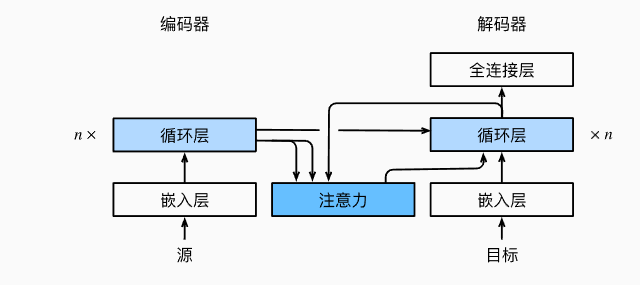

In [10]:
from IPython.display import Image
Image(filename = 'E:\Clancy\Code\动手学深度学习NLP篇\\Bahdanau.png', width=10, height=10)

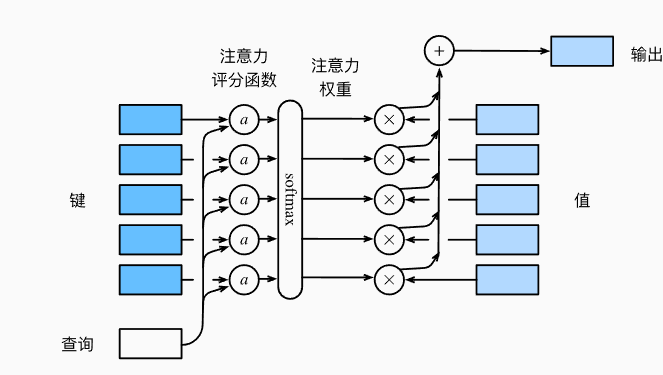

In [5]:
from IPython.display import Image
Image(filename = 'E:\Clancy\Code\动手学深度学习NLP篇\\attention.png', width=10, height=10)

In [3]:
class AttentionDecoder(d2l.Decoder):
    """带有注意力机制解码器的基本接口"""
    def __init__(self, **kwargs):
        super(AttentionDecoder,self).__init__(**kwargs)

    @property
    def attemtion_weight(self):
        raise NotImplemented

实现带有Bahdanau注意力的循环神经网络解码器

In [23]:
class Seq2SeqAttentionDecoder(AttentionDecoder):

    #这里的初始化参数就是62中的Decoder
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0, **kwargs):
        super(Seq2SeqAttentionDecoder,self).__init__(**kwargs)

        # 65中实现的加性注意力
        self.attention = d2l.AdditiveAttention(
            key_size   = num_hiddens,
            query_size = num_hiddens,
            num_hiddens= num_hiddens,
            dropout    = dropout
        )

        # 将[vocab-size]映射到[vocab-size, embed-size]
        self.embedding = nn.Embedding(vocab_size, embed_size)

        # 训练时：Decoder的输入是Encoder的final state + Decoder input
        self.rnn = nn.GRU(
            embed_size + num_hiddens,
            num_hiddens,
            num_layers,
            dropout = dropout
        )

        # 输出
        self.dense = nn.Linear(num_hiddens, vocab_size)


    def init_state(self, enc_outputs, enc_valid_lens, *args):
        # output (batch_size, num_steps, num_hiddens)
        # state  (num_layers, batch_size,num_hiddens)
        outputs, hidden_state = enc_outputs

        # 传递enc_valid_lens 目的是告诉encoder中哪里进行了padding
        return (outputs.permute(1, 0 ,2), hidden_state, enc_valid_lens)

    
    def forward(self, X, state):
        # 接受上一个的构建函数传递的信息
        enc_outputs, hidden_state, enc_valid_lens = state
        X = self.embedding(X).permute(1, 0, 2)

        # 收集各种状态，和seq2seq不同的是，这里需要收集各个状态的最后结果
        outputs, self._attention_weights = [], []

        for x in X:
            # hiddens_state[-1] 上一个时刻 encoder rnn 最后一层的输出
            #   -> hidden_state大小为(num_layers, batch_size, num_hiddens)。
            #   -> 取最后一层 (batch_size, num_hiddens)
            # query的形状为(batch_size, 1, num_hiddens)
            query = torch.unsqueeze(hidden_state[-1], dim=1)
            
            # def forward(self, queries, keys, values, valid_lens):
            # query每次都需要更新
            # 将encoder的输出作为key value, decoder的上一时刻的状态输出作为query投入到attention中
            context = self.attention(query, enc_outputs, enc_outputs, enc_valid_lens)

            # 集合本时刻输入x和attention输出context
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)

            # 投入Decoder的网络中
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)

            # 保存结果
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)

        # 全连接层变换后，outputs的形状为
        # (num_steps,batch_size,vocab_size)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state, enc_valid_lens]

    @property
    def attention_weights(self):
        return self._attention_weights


我们使用包含7个时间步的4个序列输入的小批量测试Bahdanau注意力解码器

In [24]:
encoder = d2l.Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                             num_layers=2)
encoder.eval()
decoder = Seq2SeqAttentionDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                                  num_layers=2)
decoder.eval()

X = torch.zeros((4, 7), dtype=torch.long)  # (batch_size,num_steps)
state = decoder.init_state(encoder(X), None)
output, state = decoder(X, state)
output.shape, len(state), state[0].shape, len(state[1]), state[1][0].shape

(torch.Size([4, 7, 10]), 3, torch.Size([4, 7, 16]), 2, torch.Size([4, 16]))

loss 0.019, 6652.2 tokens/sec on cuda:0


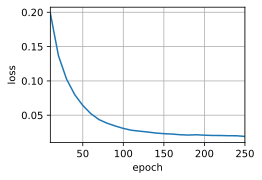

In [25]:
# 记载参数
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 250, d2l.try_gpu()

# 加载数据集
train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

# Encoder-Decoder模型
encoder = d2l.Seq2SeqEncoder(
    len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(
    len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)

# 开始训练
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [26]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']

for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq
    (
        net, eng, src_vocab, tgt_vocab, num_steps, device, True
        )
    
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est mouillé .,  bleu 0.658
i'm home . => je suis chez moi .,  bleu 1.000


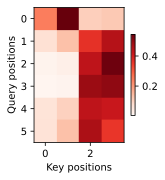

In [27]:
# 加上一个包含序列结束词元
attention_weights = torch.cat(
    [step[0][0][0] for step in dec_attention_weight_seq], 0).reshape((
    1, 1, -1, num_steps))

d2l.show_heatmaps(
    attention_weights[:, :, :, :len(engs[-1].split()) + 1].cpu(),
    xlabel='Key positions', ylabel='Query positions')